In [1]:
%load_ext autoreload
%autoreload 2

import os

os.chdir('/data/core-rad/tobweber/bernoulli-mri')

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.utils import ifft2c, get_top_k_mask
from src.datasets import ACDCDataset, BrainDataset, KneeDataset

In [2]:
from typing import Optional

import torch
from torch import Tensor
from piqa.ssim import ssim
from piqa.psnr import psnr
from piqa.utils.functional import gaussian_kernel

def mse(gt: Tensor, pred: Tensor) -> float:
    """Compute Mean Squared Error (MSE)"""
    return float(torch.mean((gt - pred) ** 2))


def nmse(gt: Tensor, pred: Tensor) -> float:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return float(torch.linalg.norm(gt - pred) ** 2 / torch.linalg.norm(gt) ** 2)


class MetricAgent:
    def __init__(self):
        self.psnrs = []
        self.ssims = []
        self.nmses = []

    def reset(self):
        self.psnrs.clear()
        self.ssims.clear()
        self.nmses.clear()

    def aggregate(self):
        r =  {
            'PSNR': sum(self.psnrs) / len(self.psnrs),
            'SSIM': sum(self.ssims) / len(self.ssims),
            'NMSE': sum(self.nmses) / len(self.nmses),
        }
        self.reset()
        return r

    def __call__(self, prediction: Tensor, target: Tensor) -> None:
            assert len(prediction) == len(target)

            # Normalize values
            for i in range(len(prediction)):
                min_val = torch.min(target[i])
                max_val = torch.max(target[i])

                target[i] = (target[i] - min_val) / (max_val - min_val)
                prediction[i] = (prediction[i] - min_val) / (max_val - min_val)
            prediction.clamp_(0, 1)

            # Compute metrics
            psnrs = psnr(prediction, target)
            self.psnrs.extend(psnrs.tolist())

            kernel = gaussian_kernel(7, sigma=1.).repeat(prediction.shape[1], 1, 1).to(prediction.device)
            ssims = ssim(prediction, target, kernel)[0]
            self.ssims.extend(ssims.tolist())
            
            nmses = [nmse(t, p) for p, t in zip(prediction, target)]
            self.nmses.extend(nmses)
            
x = torch.rand(2, 4, 256, 256).cuda()
y = torch.rand(2, 4, 256, 256).cuda()

metric_agent = MetricAgent()
metric_agent(x, y)

print(metric_agent.psnrs)
print(metric_agent.ssims)
print(metric_agent.nmses)

print(metric_agent.aggregate())

[7.798109531402588, 7.77696418762207]
[0.009815306402742863, 0.00525688985362649]
[0.49867144227027893, 0.5010098814964294]
{'PSNR': 7.787536859512329, 'SSIM': 0.007536098128184676, 'NMSE': 0.4998406618833542}


# ACDC DATASET

In [3]:
ds = ACDCDataset('/data/core-rad/data/ACDC', train=False)
dl = DataLoader(ds, batch_size=64, num_workers=8)

## Equispaced

In [4]:
from src.mask_patterns import EquiSpacedMaskFunc

acc_facs = [8, 16, 32]

for a in acc_facs:
    mask = EquiSpacedMaskFunc([0.04], [a])((1, 256, 256))[0].cuda()
    mask = mask.squeeze(2).expand(256, -1)
    mask = mask.unsqueeze(0).unsqueeze(0)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Acc. Factor:', a)
    print(metric_agent.aggregate())
    

RuntimeError: The size of tensor a (320) must match the size of tensor b (256) at non-singleton dimension 3

## 2D Variable Density

In [ ]:
def get_2d_variable_density_mask(img_size: int, acc_fac: int, scale: int = 35) -> Tensor:
    n = img_size**2 // acc_fac
    mask = torch.zeros(img_size, img_size)

    cnt = 0
    while cnt < n:
        idx = torch.randn(2) * scale + (img_size // 2)
        try:
            mask[int(idx[0]), int(idx[1])] = 1
            cnt += 1
        except IndexError:
            pass
    return mask

In [ ]:
acc_facs = [8, 16, 32]

for a in acc_facs:
    mask = get_2d_variable_density_mask(256, a, 25).cuda()
    mask = mask.unsqueeze(0).unsqueeze(0)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Acc. Factor:', a)
    print(metric_agent.aggregate())

## BERM 2D

In [ ]:
result_dirs = ['acdc_8', 'acdc_16', 'acdc_32']
acc_facs = [8, 16, 32]
result_paths = [os.path.join('logs', d, 'results.pt') for d in result_dirs]
scores = [torch.load(f)['scores'][-1].cuda() for f in result_paths]

for score, d, a in zip(scores, result_dirs, acc_facs):
    
    mask = get_top_k_mask(score.squeeze(), a)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Run:', d)
    print(metric_agent.aggregate())


## BERM 1D

In [ ]:
result_dirs = ['acdc_8_ensemble_1d', 'acdc_16_ensemble_1d', 'acdc_32_ensemble_1d']
result_dirs = ['acdc_8', 'acdc_16', 'acdc_32']
acc_facs = [8, 16, 32]
result_paths = [os.path.join('logs', d, 'results.pt') for d in result_dirs]
scores = [torch.load(f)['scores'][-1].cuda() for f in result_paths]

for score, d, a in zip(scores, result_dirs, acc_facs):
    
    mask = get_top_k_mask(score.squeeze(), a)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Run:', d)
    print(metric_agent.aggregate())


## IGS Sampling

In [11]:
from src.igs import IGS

masks = torch.load('logs/IGS/igs_acdc.pt').cuda()

acc_facs = [8, 16, 32]
ns = [IGS.get_n(acc_fac=a, img_size=256) for a in acc_facs]

for n, a in zip(ns, acc_facs):
    mask = masks[n - 2].unsqueeze(0)
    mask = mask.expand(256, -1)
    mask = mask.unsqueeze(0).unsqueeze(0)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Acc. Factor:', a)
    print(metric_agent.aggregate())
    

RuntimeError: The size of tensor a (320) must match the size of tensor b (256) at non-singleton dimension 3

# KNEE DATASET

In [3]:
ds = KneeDataset('/data/core-rad/data/knee_fastmri', train=False)
dl = DataLoader(ds, batch_size=64, num_workers=8)

## Equispaced

In [10]:
from src.mask_patterns import EquiSpacedMaskFunc

acc_facs = [4, 8, 16, 32]

for a in acc_facs:
    mask = EquiSpacedMaskFunc([0.04], [a])((1, 320, 320))[0].cuda()
    mask = mask.squeeze(2).expand(320, -1)
    mask = mask.unsqueeze(0).unsqueeze(0)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Acc. Factor:', a)
    print(metric_agent.aggregate())
    

--------------------------------------------
Acc. Factor: 4
{'PSNR': 25.07734126994616, 'SSIM': 0.635367071417373, 'NMSE': 0.05764106790513152}
--------------------------------------------
Acc. Factor: 8
{'PSNR': 23.693290314962233, 'SSIM': 0.5062190106534582, 'NMSE': 0.07931916886119275}
--------------------------------------------
Acc. Factor: 16
{'PSNR': 23.29325311765896, 'SSIM': 0.4739302235833929, 'NMSE': 0.08666314379485651}
--------------------------------------------
Acc. Factor: 32
{'PSNR': 23.056626301112136, 'SSIM': 0.44496574226444163, 'NMSE': 0.09151017244812346}


## 2D Variable Density

In [4]:
from src.mask_patterns import get_2d_variable_density_mask

In [8]:
acc_facs = [4, 8, 16, 32]

for a in acc_facs:
    
    for batch in dl:
            mask = get_2d_variable_density_mask(320, a, 25).cuda()
            mask = mask.unsqueeze(0).unsqueeze(0)
            
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Acc. Factor:', a)
    print(metric_agent.aggregate())

--------------------------------------------
Acc. Factor: 16
{'PSNR': 25.858250828989156, 'SSIM': 0.4938078708057807, 'NMSE': 0.06312083505958202}
--------------------------------------------
Acc. Factor: 32
{'PSNR': 19.856664115049707, 'SSIM': 0.3533893375122172, 'NMSE': 0.24043257930988246}


## BERM 2D

In [13]:
result_dirs = ['knee_ensemble_4', 'knee_ensemble_8', 'knee_ensemble_16', 'knee_ensemble_32']
acc_facs = [4, 8, 16, 32]
result_paths = [os.path.join('logs', d, 'results.pt') for d in result_dirs]
scores = [torch.load(f)['scores'][-1].cuda() for f in result_paths]

for score, d, a in zip(scores, result_dirs, acc_facs):
    
    mask = get_top_k_mask(score.squeeze(), a)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Run:', d)
    print(metric_agent.aggregate())


--------------------------------------------
Run: knee_ensemble_4
{'PSNR': 29.78873587655896, 'SSIM': 0.6717345168193182, 'NMSE': 0.026058458329118506}
--------------------------------------------
Run: knee_ensemble_8
{'PSNR': 28.473191626741503, 'SSIM': 0.5701136704035631, 'NMSE': 0.033737072185491}
--------------------------------------------
Run: knee_ensemble_16
{'PSNR': 27.57366242371206, 'SSIM': 0.5108296510487247, 'NMSE': 0.03985254295363416}
--------------------------------------------
Run: knee_ensemble_32
{'PSNR': 26.749428265989607, 'SSIM': 0.47274407438366745, 'NMSE': 0.046335042258137914}


## BERM 1D

In [13]:
result_dirs = ['knee_ensemble_1d_4']
acc_facs = [4, 8, 16, 32]
result_paths = [os.path.join('logs', d, 'results.pt') for d in result_dirs]
scores = [torch.load(f)['scores'][-1].cuda() for f in result_paths]

for score, d, a in zip(scores, result_dirs, acc_facs):
    
    mask = get_top_k_mask(score.squeeze(), a)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
            
            metric_agent(img_mag, img)

    print('--------------------------------------------')        
    print('Run:', d)
    print(metric_agent.aggregate())


--------------------------------------------
Run: knee_ensemble_1d_4
{'PSNR': 22.849113025064543, 'SSIM': 0.597320871813873, 'NMSE': 0.09400531083951628}


## IGS Sampling

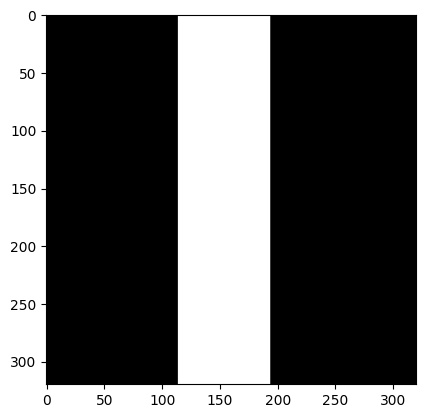

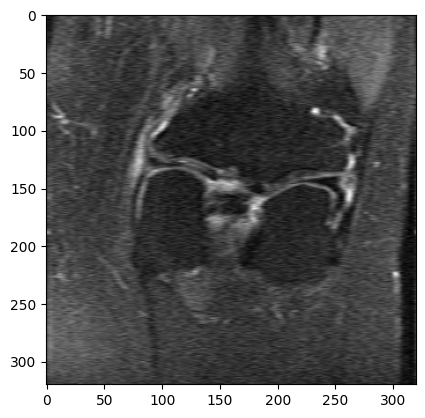

--------------------------------------------
Acc. Factor: 4
{'PSNR': 28.553062363872378, 'SSIM': 0.6449127463804768, 'NMSE': 0.0309090671160691}


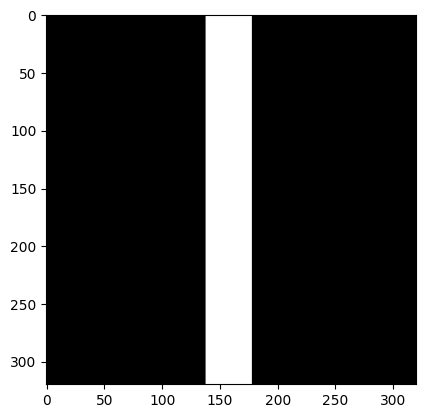

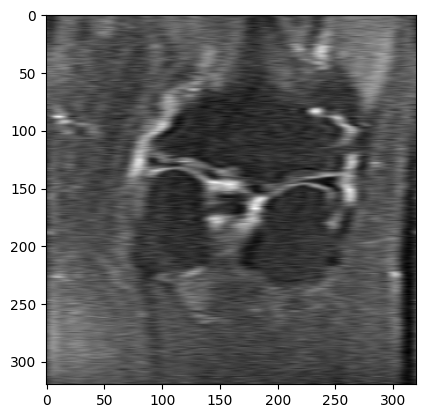

--------------------------------------------
Acc. Factor: 8
{'PSNR': 26.42844945301847, 'SSIM': 0.5315514184593215, 'NMSE': 0.046568188876197174}


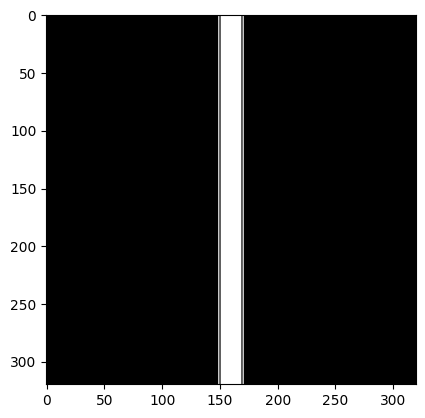

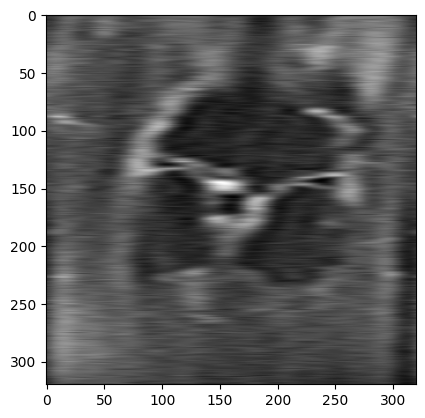

--------------------------------------------
Acc. Factor: 16
{'PSNR': 24.376477426744195, 'SSIM': 0.45805638522066155, 'NMSE': 0.06960115667610989}


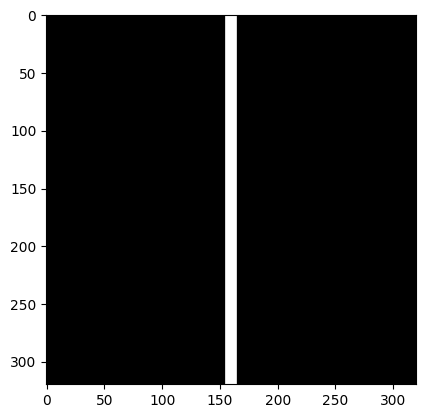

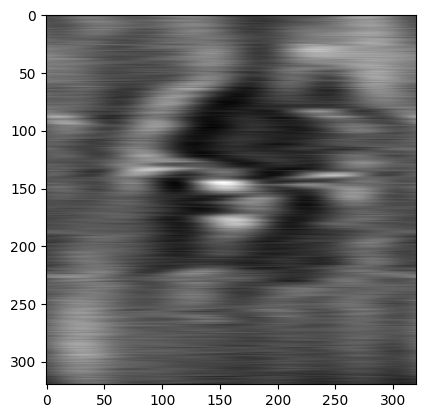

--------------------------------------------
Acc. Factor: 32
{'PSNR': 22.31381206562513, 'SSIM': 0.4090450252858516, 'NMSE': 0.10785808027147503}


In [21]:
from src.igs import IGS

masks = torch.load('logs/IGS/igs_knee.pt').cuda()

acc_facs = [4, 8, 16, 32]
ns = [IGS.get_n(acc_fac=a, img_size=320) for a in acc_facs]

for n, a in zip(ns, acc_facs):
    mask = masks[n - 2].unsqueeze(0)
    mask = mask.expand(320, -1)
    plt.imshow(mask.cpu(), cmap='gray')
    plt.show()
    mask = mask.unsqueeze(0).unsqueeze(0)
    
    for batch in dl:
            img_k = batch['k_space'].cuda()
            img = batch['img'].cuda()
            
            img_pred = ifft2c(img_k * mask + 0.0)
            img_mag = torch.abs(img_pred)
                        
            metric_agent(img_mag, img)

    plt.imshow(img_mag[32].cpu().squeeze(), cmap='gray')
    plt.show()

    print('--------------------------------------------')        
    print('Acc. Factor:', a)
    print(metric_agent.aggregate())
    

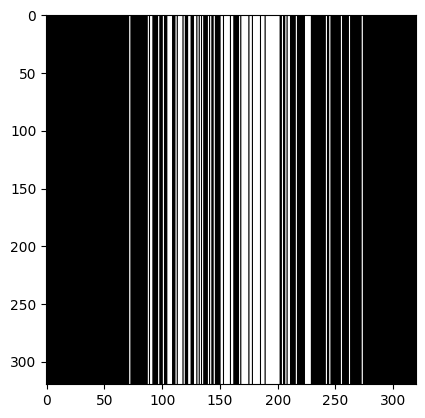

In [12]:
acc_facs = [4]
num_members = 10

for acc_fac in acc_facs:
    path_stem = f'logs/knee_ensemble_1d_{acc_fac}_m'
    
    paths = [path_stem + str(i) + '/results.pt' for i in range(1, num_members + 1)]
    scores = [torch.load(f)['scores'][-1].cuda() for f in paths]

    scores_sum = torch.sum(torch.cat(scores), dim=(0,1))

    mask = get_top_k_mask(scores_sum, acc_fac)
    plt.imshow(mask.cpu(), cmap='gray')
    plt.show()

    new_path = f'logs/knee_ensemble_1d_{acc_fac}'
    os.makedirs(new_path, exist_ok=True)
    torch.save({
        'scores': [scores_sum.cpu()]
    }, os.path.join(new_path, 'results.pt'))